# 1.MORDM OPTIMIZATION

# 1.1 Generate random policies

In [1]:
import pandas as pd
import numpy as np

from ema_workbench import load_results
from ema_workbench import Scenario

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

In [2]:
# load the basecase results
experiments, outcomes = load_results('../results/basecase_results.tar.gz') 
outcomes_df = pd.DataFrame.from_dict(outcomes)

In [3]:
# load the Series which defines which are the experiments within the established threshold in the first part
y3 = pd.read_csv('../results/boolean_worst_scenarios.csv').iloc[:, 1:]

# Convert Series to a list
y = np.array(y3).squeeze()

In [4]:
# Filter out experiments which obey the established threshold
experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

In [5]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
                    

    return df_aggregate_time, df_aggregate_time_location

In [6]:
# Aggregate the outcome values
df_agg_t, df_agg_tl = aggregate_df(outcomes_df)

In the next step we want to select the worst case scnearios in order to optimize over them. For this, we rank all the different columns in the outcomes dataframe from highesto to lowest value. Then, we sum up the rank number and chose the scenarios which have the highest rank, i.e. the ones that perform the worst.

In [7]:
# Given that we're ranking on the base case, the dike investment costs are zero. Therfore, we drop those columns
dike_inv = ['A.1_Dike Investment Costs time aggregate', 'A.2_Dike Investment Costs time aggregate', 
            'A.3_Dike Investment Costs time aggregate', 'A.4_Dike Investment Costs time aggregate', 'A.5_Dike Investment Costs time aggregate']

df_agg_t.drop(columns=dike_inv, inplace=True)

In [8]:
# We rank each column and sum over each row value to obtain the rank of each scenario for Expected annual damage and expected number of deaths
rank_df = pd.DataFrame()
for column in df_agg_t.columns:
    rank_df[column] = df_agg_t[column].rank()

rank_df['Final rank'] = rank_df.sum(axis=1)

In [9]:
# In order to sort out the values for the top 5 worst scenarios, we retrieve their index to then filter them out from the experiments 
worst_5_df = rank_df.sort_values(by='Final rank',ascending=False).head()
worst_5_ind = list(worst_5_df.index)

# Finally, we filter the worst scenarios out and only get back the first 19 columns, which correspond to the uncertainty values in each scenario
scenarios_df = experiments_of_interest.iloc[worst_5_ind,:19]
indexes_scenarios = scenarios_df.index.to_list()
indexes_scenarios

[3794, 2761, 1322, 4347, 1009]

Now that we have the values of the uncertainties that correspond to the top 5 worst case scenarios, we specify them in the workbench and perform Multi-Scenario MORDM. ...

In [10]:
# Specify the scenarios in the workbench
scenarios = [Scenario(f"{index}", **row) for index, row in scenarios_df.iterrows()]

In [11]:
scenarios

[Scenario({'A.0_ID flood wave shape': 126.0, 'A.1_Bmax': 34.600617826141814, 'A.1_Brate': 1.0, 'A.1_pfail': 0.3006762899834219, 'A.2_Bmax': 249.3032329505288, 'A.2_Brate': 1.0, 'A.2_pfail': 0.2708055189445016, 'A.3_Bmax': 320.3575399480371, 'A.3_Brate': 10.0, 'A.3_pfail': 0.3525380917163722, 'A.4_Bmax': 138.1003364083849, 'A.4_Brate': 1.5, 'A.4_pfail': 0.4097890022492976, 'A.5_Bmax': 295.78188991686, 'A.5_Brate': 1.0, 'A.5_pfail': 0.0157253956901981, 'discount rate 0': 1.5, 'discount rate 1': 4.5, 'discount rate 2': 2.5}),
 Scenario({'A.0_ID flood wave shape': 99.0, 'A.1_Bmax': 90.57060496955673, 'A.1_Brate': 1.5, 'A.1_pfail': 0.3302728187453683, 'A.2_Bmax': 230.9039500880189, 'A.2_Brate': 1.5, 'A.2_pfail': 0.4690354722563472, 'A.3_Bmax': 158.93709922424813, 'A.3_Brate': 10.0, 'A.3_pfail': 0.1198404706872176, 'A.4_Bmax': 343.5076658817105, 'A.4_Brate': 10.0, 'A.4_pfail': 0.019355206078852, 'A.5_Bmax': 301.6514820610985, 'A.5_Brate': 1.5, 'A.5_pfail': 0.7763768929549784, 'discount rate 

In [12]:
# Import the maximum and minimum values found across performing experiments for 100 policies across 400 scenarios
import pickle
with open('../results/min_max_range_basecase.pickle', 'rb') as f:
    max_range_bc, min_range_bc = pickle.load(f)
with open('../results/min_max_range_randompolicies.pickle', 'rb') as f:
    max_range_rp, min_range_rp = pickle.load(f)

In [13]:
max_range = pd.concat([max_range_bc, max_range_rp], axis=1)
min_range = pd.concat([min_range_bc, min_range_rp], axis=1)

In [14]:
max_range = max_range.max(axis=1)
min_range = min_range.min(axis=1)
max_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)
min_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)

In [15]:
max_range

Expected Annual Damage time location aggregate       6.790428e+09
Dike Investment Costs time location aggregate        9.334020e+08
Expected Number of Deaths time location aggregate    5.855678e+00
Expected Evacuation Costs time aggregate             1.246373e+05
dtype: float64

In [16]:
from problem_formulation_altered import get_model_for_problem_formulation_altered

In [17]:
# Initialise the altered formulation
dike_model, planning_steps = get_model_for_problem_formulation_altered(min_range,max_range)

deaths = ['Expected Number of Deaths']

max_num_deaths = 0.0001 * 3 * 5


# MENTION THAT WE DONT ADD THIS?
# Adding the constraint for Room for the total number of deaths.
constraints = [Constraint("Max number of deaths", outcome_names=deaths,
                          function=lambda x:max(0, x-max_num_deaths))]


In [18]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [19]:
# perform the analysis
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench import SequentialEvaluator


convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                       EpsilonProgress()]

nfe = 7500
results_deep = []
convergence_all = []


# #epsilons=[1e7, 1e6, 1e3, 0.01]

#We define the epsilons as a 100th part of the maximum value of the outcome
for scenario in scenarios:
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        epsilons=[1e7, 1e6, 0.00001],
                                        convergence=convergence_metrics, reference=scenario, constraints=constraints)
                                        
        
        results_deep.append(results_runs)
        convergence_all.append(convergence)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1 nfe
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1 nfe
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1 nfe
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


In [1]:
from ema_workbench import save_results

for i in range(len(results_deep)):
    save_results((results_deep[i], convergence_all[i]), f'../results/mordm_7500_rp_scenario{i}.tar.gz')

NameError: name 'results_deep' is not defined

In [21]:
# from ema_workbench import load_results

# results_deep = []
# convergence_all = []

# for i in range(4):
#     result, convergence = load_results(f'../results/mordm_10000_100p_scenario{i}.tar.gz')
#     results_deep.append(result)
#     convergence_all.append(convergence)
    
    


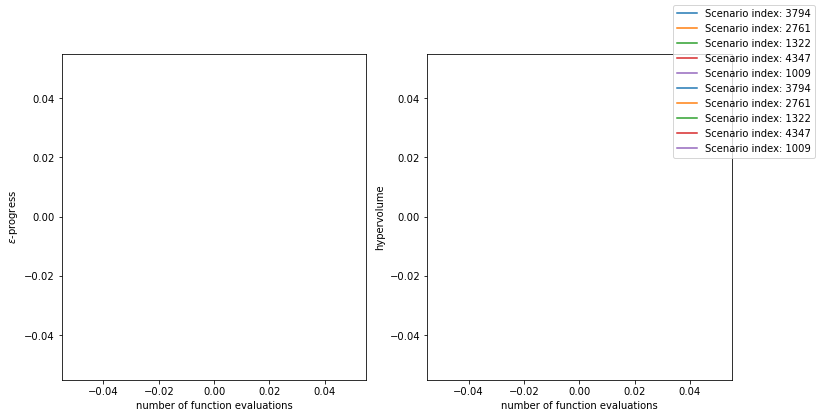

In [22]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# # plot the results
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))

# for i, con in enumerate(convergence_all):
#     ax1.plot(con['nfe'], con['epsilon_progress'], label=f'Scenario index: {indexes_scenarios[i]}')
#     ax2.plot(con['nfe'], con['hypervolume'], label=f'Scenario index: {indexes_scenarios[i]}')

# ax1.set_ylabel('$\epsilon$-progress')
# ax2.set_ylabel('hypervolume')

# ax1.set_xlabel('number of function evaluations')
# ax2.set_xlabel('number of function evaluations')
# fig.legend()
# plt.show()

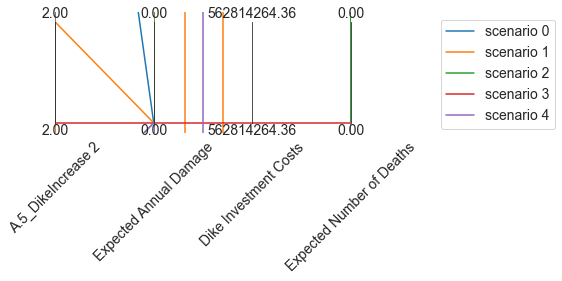

In [23]:
# from ema_workbench.analysis import parcoords


# colors = iter(sns.color_palette())

# data = results_deep[3].iloc[:, -4:]
# limits = parcoords.get_limits(data)

# # limits.loc[0, ['inertia', 'reliability']] = 1
# # limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# # limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# # limits.loc[1, :] = 0
# paraxes = parcoords.ParallelAxes(limits, rot=45)


# for i, result in enumerate(results_deep):
#     color = next(colors)
#     data = result.iloc[:, -4:]
#     paraxes.plot(data, label=f'scenario {i}', color=color)

# paraxes.legend()
# plt.show()


Re-evaluation

In [24]:
from ema_workbench import Policy

policies = []
for i, result in enumerate(results_deep):
    outcomes_of_interest = result.iloc[:, :-4]
    for j, row in outcomes_of_interest.iterrows():
        policy = Policy(f'scenario {i} policy {j}', **row.to_dict())
        policies.append(policy)

In [25]:
from problem_formulation import get_model_for_problem_formulation

# We use the original problem formulation to account for the RfR policies
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [26]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)
    
experiments_reev, outcomes_reev = reeevaluation_results

In [27]:
from ema_workbench import save_results
save_results((experiments_reev, outcomes_reev), f'../results/mordm_exp_2_1000.tar.gz')

# experiments_reev, outcomes_reev = load_results('../results/mordm_exp_1000.tar.gz') 
# outcomes_reev_df = pd.DataFrame.from_dict(outcomes_reev)

[MainProcess/INFO] results loaded succesfully from D:\Willy\Documents\GitHub\Model_based_decision_making\EPA1361\final assignment\results\mordm_exp_1000.tar.gz


Comparing both cells below we can see how we have 66 unique policies.

In [28]:
experiments_reev.iloc[:,19:-3].duplicated().value_counts()

True     65934
False       66
dtype: int64

In [29]:
experiments_reev['policy'].nunique()

66

We now only chose the policies that keep the number of deaths under the threshold in ALL scenarios

In [30]:
outcomes_reev_df.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,6.600000e+04,6.600000e+04,6.600000e+04,66000.000000,66000.000000
mean,1.316897e+08,3.806835e+07,1.776502e+09,4829.451803,0.036388
std,3.046821e+08,3.271074e+07,3.446195e+08,9926.987000,0.128585
min,0.000000e+00,0.000000e+00,8.427000e+08,0.000000,0.000000
25%,1.345577e+07,8.453407e+06,1.526400e+09,372.003726,0.002803
50%,3.948520e+07,2.819203e+07,1.828800e+09,1423.017598,0.008177
75%,1.027857e+08,7.204073e+07,2.046600e+09,4145.804143,0.025947
max,3.676109e+09,1.239901e+08,2.131200e+09,110042.946693,3.331505


In [31]:
outcomes_reev_df['policy']= experiments_reev['policy']
policy_names = outcomes_reev_df.policy.unique()

policies_of_interest = []
for policy in policy_names:
    policy_df = outcomes_reev_df[outcomes_reev_df['policy'] == policy]
    policy_df_logical = policy_df['Expected Number of Deaths'] > (0.0001*3*5)
    type(policy_df_logical)
    if policy_df_logical.any():
        continue
    else:
        policies_of_interest.append(policy)

policies_of_interest

[]

We can see that there is no policy that obeys the threshold under all scenarios. We therefore calculate the robustness using the thresholds.......

In [32]:
outcomes_reev_df_death= outcomes_reev_df[outcomes_reev_df['Expected Number of Deaths']<=(0.0001*3*5)]
outcomes_reev_df_death

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,policy
28,1.266035e+06,0,1.098800e+09,0.000000,0.000790,scenario 0 policy 0
39,0.000000e+00,0,1.098800e+09,0.000000,0.000000,scenario 0 policy 0
56,0.000000e+00,0,1.098800e+09,0.000000,0.000000,scenario 0 policy 0
103,1.387291e+06,0,1.098800e+09,0.000000,0.000650,scenario 0 policy 0
114,2.486925e+06,0,1.098800e+09,0.000000,0.001282,scenario 0 policy 0
...,...,...,...,...,...,...
65994,0.000000e+00,123990093,1.488100e+09,0.000000,0.000000,scenario 3 policy 14
65995,5.529920e+06,123990093,1.488100e+09,221.157720,0.001004,scenario 3 policy 14
65996,1.265475e+06,123990093,1.488100e+09,31.618770,0.000336,scenario 3 policy 14
65997,0.000000e+00,123990093,1.488100e+09,0.000000,0.000000,scenario 3 policy 14


In [33]:
#Por ahora probamos sin evacuation costs y damage, que no estan especificados

max_deaths = 0.0001
max_rfr_costs = 1.1e9
max_dike_costs = 3.04e8

thresholds = {'Dike Investment Costs':max_dike_costs, 'RfR Investment Costs':max_rfr_costs, 'Expected Number of Deaths':max_deaths}

overall_scores = {}
for policy in experiments_reev.policy.unique():
    logical = experiments_reev.policy == policy
    scores = {}
    for k, v in outcomes_reev.items():
        try:
            n = np.sum(v[logical]<=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [34]:
#overall_scores_filtered = overall_scores[(overall_scores['Expected Number of Deaths'] >= 0.990) & (overall_scores['RfR Investment Costs'] == 0.0)]

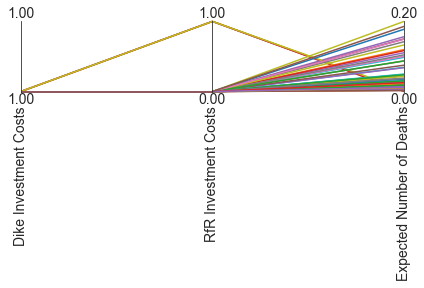

In [35]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

In [36]:
import functools

def robustness(direction, threshold, data):
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e3 # makes numbers nicer CAREFUL WITH UNITS
    
SMALLER = 'SMALLER'


max_deaths = 0.0001
max_rfr_costs = 1.1e9
max_dike_costs = 3.04e8

Expected_Annual_Damage = costs
Dike_Investment_Costs = functools.partial(robustness, SMALLER, max_dike_costs)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, max_deaths)
RfR_Investment_Costs = functools.partial(robustness, SMALLER, max_rfr_costs)
Evacuation_Costs = costs

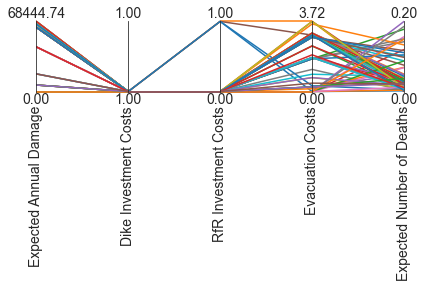

In [37]:
from ema_workbench.analysis import parcoords


funcs = {'Expected Annual Damage': Expected_Annual_Damage,
         'Dike Investment Costs': Dike_Investment_Costs,
         'Expected Number of Deaths':Expected_Number_of_Deaths,
         'RfR Investment Costs':RfR_Investment_Costs,       
         'Evacuation Costs': Evacuation_Costs}

total_scores = {}
for policy in np.unique(experiments_reev['policy']):
    scores = {}
    logical = experiments_reev['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes_reev.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T#.reset_index(drop=True)
limits = parcoords.get_limits(data)
# limits.loc[0, :] = 0
# limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [38]:
data_death = data.sort_values(by=['Expected Number of Deaths']).tail(5)
data_death

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
scenario 2 policy 10,62763.533132,1.0,0.0,1.737567,0.152
scenario 0 policy 4,0.000000,1.0,0.0,0.000000,0.158
scenario 2 policy 15,62763.533132,1.0,0.0,1.737567,0.179
scenario 3 policy 14,0.000000,1.0,0.0,0.000000,0.187
scenario 2 policy 3,62763.533132,1.0,0.0,0.000000,0.201


In [39]:
outcomes_names = list(outcomes_reev.keys())
n_policies = experiments_reev['policy'].nunique()
n_experiments = len(experiments_reev)
n_exp_pol = n_experiments/n_policies

In [40]:
# To calculate the regret we find the maximum value for each outcome under each policy with the same values for the uncertainties
# Then, we calculate the regret and find the maximum regret to study which is the policy that has the lowest maximum regret
final_regret = {}
for outcome in outcomes_names:
    policy_dict = {}

    for i in range(1, n_policies+1):
        # We first find the maximum value for each outcome under all policies
        policy_row = outcomes_reev[outcome][int(n_exp_pol*(i-1)): int(n_exp_pol*i)]
        policy_dict['policy'+f"{i}"] = policy_row
    policy_df = pd.DataFrame.from_dict(policy_dict)
    maxValuesObj = policy_df.max(axis=1)
    regret_row = abs(policy_df.sub(maxValuesObj, axis='index'))
    final_regret[outcome] = regret_row.max()

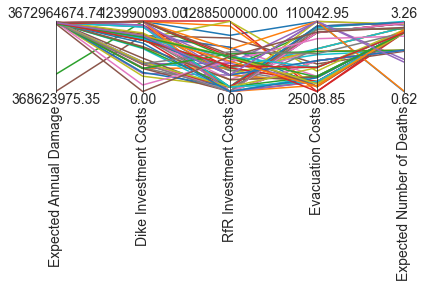

In [41]:
regret_df = pd.DataFrame.from_dict(final_regret)
limits = parcoords.get_limits(regret_df)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(regret_df)
plt.show()

In [42]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments_reev['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes_reev[outcome.name], 
                         "policy":experiments_reev['policy'],
                         "scenario":experiments_reev['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

C:\Users\Willy\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


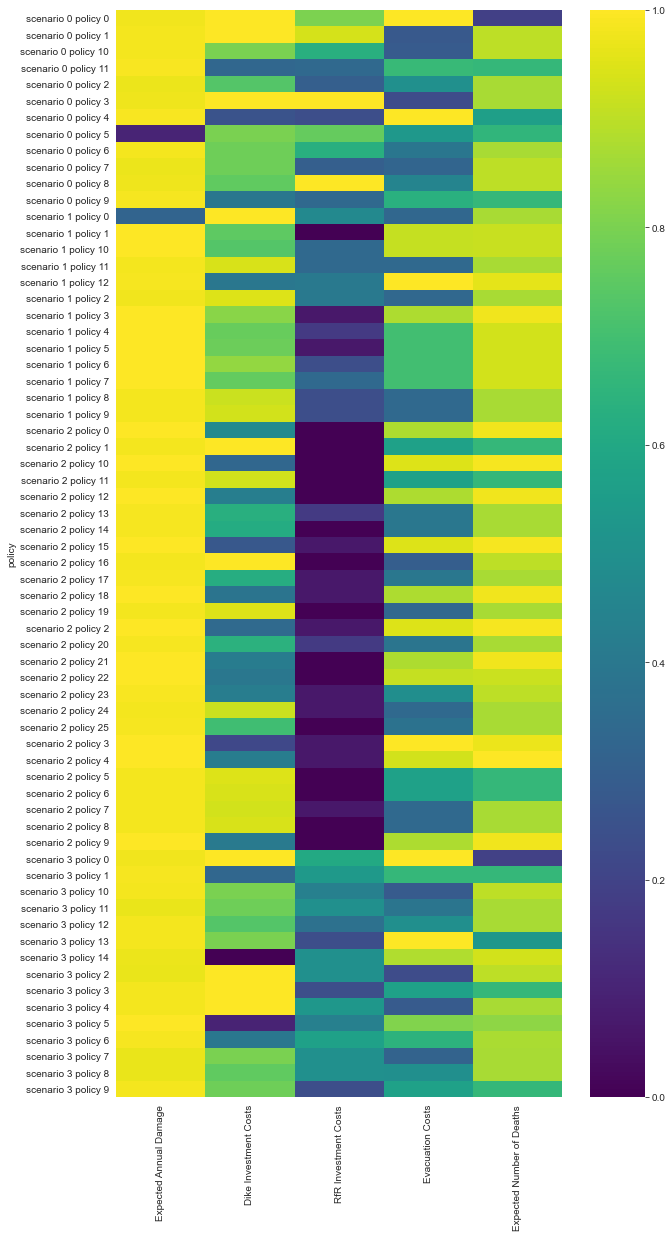

In [43]:
max_regret = pd.DataFrame(max_regret)

fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=False, ax=ax)
plt.show()

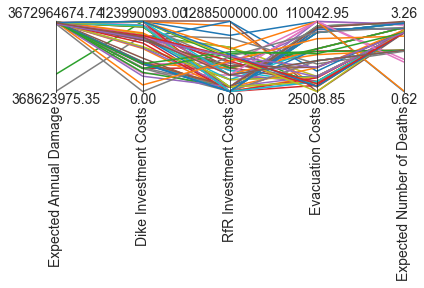

In [44]:
colors = sns.color_palette()

data = max_regret

limits = parcoords.get_limits(data)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [45]:
max_regret_filtered = max_regret.sort_values(by=['Expected Number of Deaths']).head(5)
max_regret_filtered

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
scenario 0 policy 0,3.594808e+09,123990093,1.032400e+09,110042.946693,0.617577
scenario 3 policy 0,3.598394e+09,123990093,7.763000e+08,110042.946693,0.633566
scenario 3 policy 13,3.615064e+09,98952879,3.024000e+08,110042.946693,1.726963
scenario 0 policy 4,3.630246e+09,31953880,3.024000e+08,110042.946693,1.829043
scenario 0 policy 5,3.686240e+08,98952879,9.838000e+08,58540.345020,2.133345


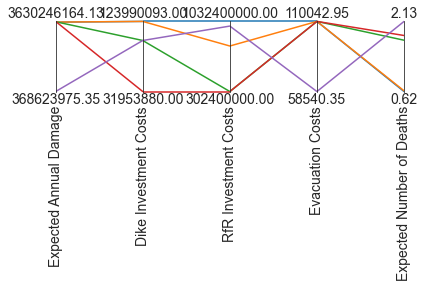

In [46]:
limits = parcoords.get_limits(max_regret_filtered)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(max_regret_filtered)
plt.show()

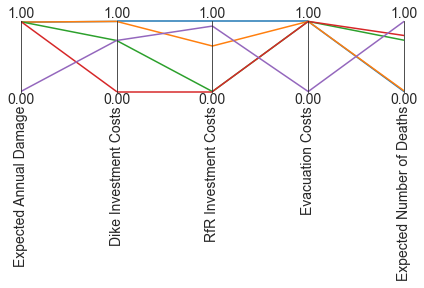

In [47]:
import pandas as pd
from sklearn import preprocessing

x = max_regret_filtered.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
max_regret_filtered_norm = pd.DataFrame(x_scaled, columns=max_regret_filtered.columns)


limits = parcoords.get_limits(max_regret_filtered_norm)
#limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(max_regret_filtered_norm)
plt.show()

In [48]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

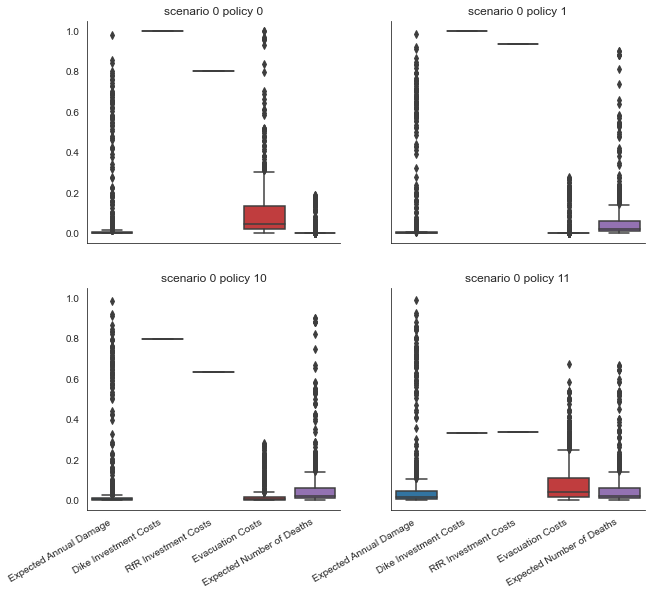

In [49]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],        
        axes[1,0],axes[1,1]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
fig.autofmt_xdate()
plt.show()

In [50]:
#esto sirve para filtrar de outcomes
outcomes_reev_logical = outcomes_reev['Expected Number of Deaths'] <= 0.0001
experiments_reev_of_interest = experiments_reev.loc[outcomes_reev_logical]
# outcomes_reev_of_interest_df = pd.DataFrame({k:v[outcomes_reev_logical] for k,v in outcomes_reev.items()})

In [51]:
max_rfr_costs = 1.1e9
max_dike_costs = 304e6
outcomes_reev_logical_2 = outcomes_reev_of_interest_df['RfR Investment Costs'] <= max_rfr_costs
outcomes_reev_of_interest_df = pd.DataFrame({k:v[outcomes_reev_logical_2] for k,v in outcomes_reev_of_interest_df.items()})

NameError: name 'outcomes_reev_of_interest_df' is not defined

In [ ]:
outcomes_reev_of_interest_df

In [ ]:
# plot results of domain criterion
limits = parcoords.get_limits(outcomes_reev_of_interest_df)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(outcomes_reev_of_interest_df)
plt.rcParams["figure.figsize"] = (10,15)
plt.show()

# End of document

# 1.3 Re-evaluate candidate solutions under uncertainty

In [ ]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [ ]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

In [ ]:
from ema_workbench import save_results

save_results(results, 'MORO_reevaluation.tar.gz')

In [ ]:
policies.to_csv('moro polices.csv')

In [ ]:
import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

In [ ]:

data = overall_robustness.loc[:, 
                              ['Expected Number of Deaths', 'Expected Annual Damage', 'Total Investment Costs']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()